# Final Cover Plot
The hope of this project is to generate the “Goldilocks” zone for miRNA cover. To do this, we are using the previously developed “random cover” simulation compared to a newly generated “optimized cover” using a greedy algorithm. These two curves will be plotted together with an X marking each species' actual seed cover. 

For organization purposes, the random cover and optimized cover will be generated separately, with final data being outputted to folders that will be consolidated in the “final cover plot” program. 
Additionally, we will be using three datasets: TargetScan data (which selects only the most represented 3’UTR),  Biomart+consolidation (which considers all 3’UTR and removes repeats), and Biomart+generation (which generates a gene that contains all versions of transcriptID).  Each of these datasets represents different ways miRNA interacts in the cell, therefore comparing the results of each dataset will allow us to determine which method is most effective. 

This script takes the data generated by "random cover" and "optimized cover" and creates a plot containing the 'goldilocks zone'. 

In [34]:
import os
import glob
import numpy as np
import re
from matplotlib import pyplot as plt
import ast
from scipy.optimize import curve_fit
#from scipy.misc import derivative
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pandas as pd
from matplotlib.path import Path

In [35]:
def extract_latin_name(name):
   match = re.search(r"\((.*?)\)", name)
   if match:
        return match.group(1)
    
x = np.arange(10)
y = np.random.rand(10)

# two separate strokes: diagonal down-up and diagonal up-down
verts = [(-1, -1), (1, 1), (-1, 1), (1, -1)]
codes = [Path.MOVETO, Path.LINETO, Path.MOVETO, Path.LINETO]
x_marker = Path(verts, codes)

In [4]:
species_list = [
    #invertabrates
    ('Caenorhabditis elegans (PRJNA13758) genes (WBcel235)','Roundworm (Caenorhabditis elegans)'),
    ('Drosophila melanogaster (Fruit fly) genes (BDGP6.46)','Fruit fly (Drosophila melanogaster)'),
    ("Caenorhabditis briggsae genes","Roundworm (Caenorhabditis briggsae)"),
    ("Drosophila ananassae genes","Fruit fly (Drosophila ananassae)"),
    ("Drosophila mojavensis genes","Fruit fly (Drosophila mojavensis)"),
    ("Drosophila simulans genes","Fruit fly (Drosophila simulans)"),
    ("Drosophila yakuba genes","Fruit fly (Drosophila yakuba)"),
    ("Ciona intestinalis genes","Sea Squirt (Ciona intestinalis)"),
    ("Branchiostoma floridae genes","Florida lancelet (Branchiostoma floridae)"),
    ("Strongylocentrotus purpuratus genes","Purple sea urchin (Strongylocentrotus purpuratus)"),
    ("Octopus bimaculoides (California two-spot octopus, UCB-OBI-ISO-001)","California two-spot octopus (Octopus bimaculoides)"),
    #vertabrates
    ('Lamprey genes (Pmarinus_7.0)','Sea Lamprey (Petromyzon marinus)'),
    ('Hagfish genes (Eburgeri_3.2)','Inshore hagfish (Eptatretus burgeri)'),
    ('Elephant shark genes (Callorhinchus_milii-6.1.3)','Australian ghostshark (Callorhinchus milii)'),
    ('Spotted gar genes (LepOcu1)','Spotted gar (Lepisosteus oculatus)'),
    ('Zebrafish genes (GRCz11)','Zebrafish (Danio rerio)'),
    ('Atlantic cod genes (gadMor3.0)','Cod (Gadus morhua)'),
    ('Coelacanth genes (LatCha1)','Coelacanth (Latimeria chalumnae)'),
    ('Tropical clawed frog genes (Xenopus_tropicalis_v9.1)','Tropical clawed frog (Xenopus tropicalis)'),
    ('Tuatara genes (ASM311381v1)','Tuatara (Sphenodon punctatus)'),
    ('Green anole genes (AnoCar2.0v2)','Green anole lizard (Anolis carolinensis)'),
    ('Painted turtle genes (Chrysemys_picta_bellii-3.0.3)','Western painted turtle (Chrysemys picta bellii)'),
    ('Zebra finch genes (bTaeGut1_v1.p)','Zebra finch (Taeniopygia guttata)'),
    ('Chicken (maternal Broiler) genes (bGalGal1.mat.broiler.GRCg7b)','Chicken (Gallus gallus)'),
    ('Platypus genes (mOrnAna1.p.v1)','Platypus (Ornithorhynchus anatinus)'),
    ('Opossum genes (ASM229v1)','Gray short-tailed opossum (Monodelphis domestica)'),
    ('Armadillo genes (Dasnov3.0)','Nine-banded armadillo (Dasypus novemcinctus)'),
    ('Cow genes (ARS-UCD1.2)','Cow (Bos taurus)'),
    ('Dog genes (ROS_Cfam_1.0)','Dog (Canis familiaris)'),
    ('Rabbit genes (OryCun2.0)','Rabbit (Oryctolagus cuniculus)'),
    ('Guinea Pig genes (Cavpor3.0)','Guinea pig (Cavia porcellus)'),
    ('Rat genes (mRatBN7.2)','Norway rat (Rattus norvegicus)'),
    ('Mouse genes (GRCm39)','House mouse (Mus musculus)'),
    ('Human genes (GRCh38.p13)','Human (Homo sapiens)')
]

In [5]:
def find_y_fit(x,y,n):
    def glf(x, a, b, c, d, g):
        return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
    popt, pcov = curve_fit(glf, x, y, p0=[0,1,np.quantile(x,.25),np.max(y),.4], maxfev=10000)
    
    return glf(n,*popt)

In [46]:
def simulate_plot(genome_filename, mature_filename, canon_site):
    df = pd.read_csv("Genome Size Data/Seed vs 3'UTR Data (site "+canon_site+" ).csv")
    index = df[df['Species']==mature_filename].index
    genome_size = int(df['Gene Number'][index])

    #format optimal data
    data_o = {}
    new_file_path = "Simulated Optimal Coverage/"+genome_filename+"_simulation/Canon Site "+canon_site
    for ID in glob.glob(os.path.join(new_file_path, '*.txt')):
           with open(os.path.join(os.getcwd(), ID), 'r') as f:
                data_o[int(os.path.basename(ID).split('/')[-1].strip(".tx"))] = (ast.literal_eval(f.read()))
    keys_o = list(data_o.keys())
    keys_o.sort()
    data_o = {i: data_o[i] for i in keys_o}
    x_o = []
    y_o = []
    
    for key in data_o.keys():
        for i in data_o[key]:
            y_o.append(i/genome_size)
            x_o.append(key)
            
    #format random data
    data_r = {}
    new_file_path = "Simulated Random Coverage/"+genome_filename+"_simulation/Canon Site "+canon_site
    for ID in glob.glob(os.path.join(new_file_path, '*.txt')):
           with open(os.path.join(os.getcwd(), ID), 'r') as f:
                data_r[int(os.path.basename(ID).split('/')[-1].strip(".tx"))] = (ast.literal_eval(f.read()))
    keys_r = list(data_r.keys())
    keys_r.sort()
    data_r = {i: data_r[i] for i in keys_r}
    x_r = []
    y_r = []
    for key in data_r.keys():
        for i in data_r[key]:
            y_r.append(i/genome_size)
            x_r.append(key)

    #font
    font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}
    plt.rc('font', **font)
    plt.rcParams['svg.fonttype'] = 'none'
    
    #colors
    c_optimal = '#cb275a'
    c_random = '#f3b432'
    c_real = '#f6501d'
    
    #figure
    fig,ax = plt.subplots(figsize=(6,4))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.titlepad'] = 14
    plt.title(mature_filename, fontsize=12)
    
    #axis
    """MAKE YLABELS LARGER, DO IT FOR TRANSCRIPTS TARGETED AS WELL"""
    y_label_size = 16
    ax.set_ylabel("% of Transcriptome Targeted", fontsize=y_label_size)
    #CHANGE yticks from 0-1 to 0-100 (BAD DUCT TAPE SOLUTION)
    ticks = np.linspace(0, 1, 6) 
    labels = [str(int(t * 100)) for t in ticks]


    plt.yticks(ticks, labels)
            
    #plot boxplot and line plot
    line_random = sns.lineplot(x=x_r, y=y_r, errorbar=('ci', 100), c = c_random)
    line_optimal = sns.lineplot(x=x_o, y=y_o, errorbar=('ci', 100), c = c_optimal)
    
    #load real coverage
    new_file_path = "Real Coverage/"+mature_filename+"/Canon Site "+canon_site
    with open(new_file_path+"/Norm_v.txt", 'r') as f:
        norm_data = ast.literal_eval(f.read())
        norm_data[1]=norm_data[1]/genome_size
    """THIS ISN't SHOWING UP, FIX"""
    plt.text(norm_data[0], norm_data[1], "X", color="red", fontsize=13, ha="center", va="center")
    
    #dotted lines:
    optimal_y = find_y_fit(x_o, y_o, norm_data[0])
    optimal_d = optimal_y-norm_data[1]  
    plt.vlines(norm_data[0],norm_data[1] , optimal_y, linestyle="dashed", color = c_optimal, label="Distance to Optimal Line: "+str("%.2f"%(genome_size*optimal_d)))
    
    random_y = find_y_fit(x_r,y_r, norm_data[0])
    random_d = random_y-norm_data[1]  
    plt.vlines(norm_data[0],norm_data[1] , random_y, linestyle="dashed", color = c_random, label = "Distance to Random Line: "+str("%.2f" %(genome_size*random_d)))
    
    #legend
    """MAKE THIS LEGEND BIGGER"""
    plt.legend(fontsize=14)
    
    #zoom in
    # plt.rcParams.update({'font.size': 12})
    # plt.rcParams.update({'font.weight': 'normal'})
    
    # y_margin = int(max(y_r))/20
    # x_margin = 75
    # x1, x2, y1, y2 = norm_data[0]-x_margin,norm_data[0]+x_margin,norm_data[1]-y_margin,norm_data[1]+y_margin
    
    # d1 = ((.5**2)+(min(data_r[700])/max(data_r[1600])**2))**.5
    # beta = 1.4
    # gamma = .07
    # z = 13*d1
    # axins1 = zoomed_inset_axes(ax, zoom = z, loc=7)
    
    # sns.lineplot(x=x_r, y=y_r, errorbar=('ci', 100), c = c_random, ax = axins1)
    # sns.lineplot(x=x_o, y=y_o, errorbar=('ci', 100), c = c_optimal, ax = axins1)
    
    # axins1.plot(norm_data[0], norm_data[1], marker="x", markersize=10, markeredgecolor="red")
    
    # axins1.vlines(norm_data[0],norm_data[1] , optimal_y, linestyle="dashed", color = c_optimal, label="Distance to Optimal Line: "+str("%.2f"%(genome_size*optimal_d)))
    # axins1.vlines(norm_data[0],norm_data[1] , random_y, linestyle="dashed", color = c_random, label = "Distance to Random Line: "+str("%.2f" %(genome_size*random_d)))
    
    # axins1.set_xlim(x1, x2)
    # axins1.set_ylim(y1, y2)
    # mark_inset(ax, axins1, loc1=1, loc2=3, fc="none", ec="0.5")
    
    
    #axis
    ax2 = ax.twinx()
    ax2.set_ylabel("Transcripts Targeted", fontsize=y_label_size)
    ax2.set_ylim(0, genome_size)
    
    
    #save figure
    file_path = "seed_coverage_raster/"
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    plt.savefig(file_path +"/"+genome_filename+ " Canon Site " + canon_site +" Range Plot.svg", dpi = 120, facecolor=fig.get_facecolor(), bbox_inches='tight')
    plt.show()

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


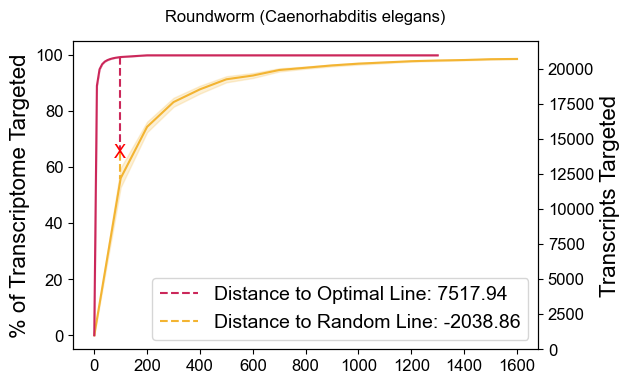

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


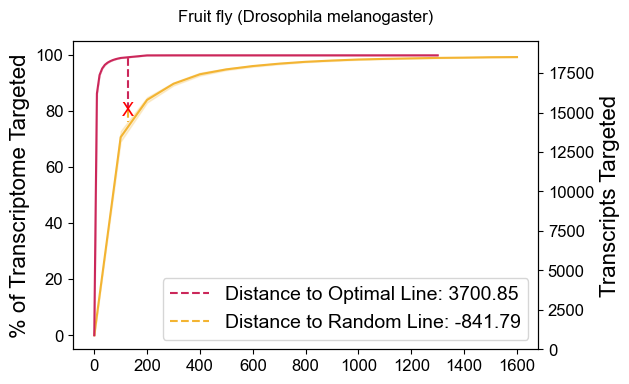

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


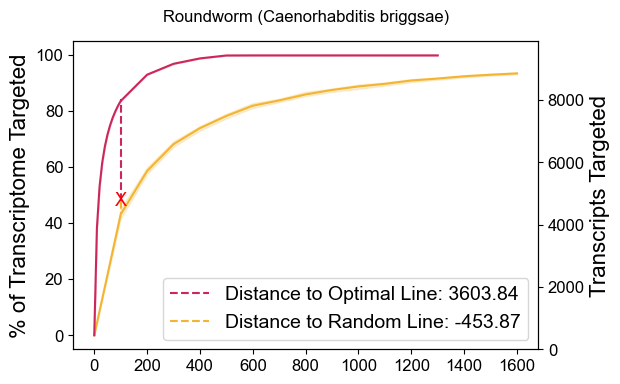

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


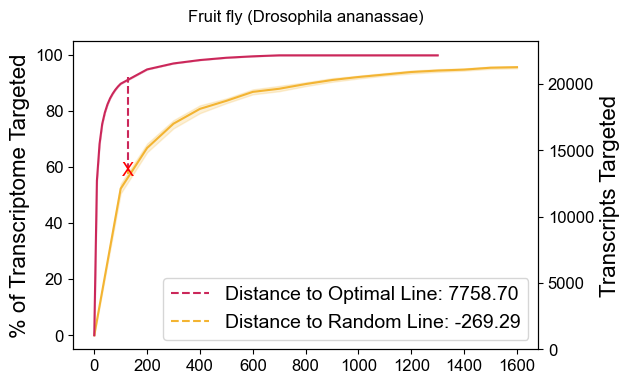

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


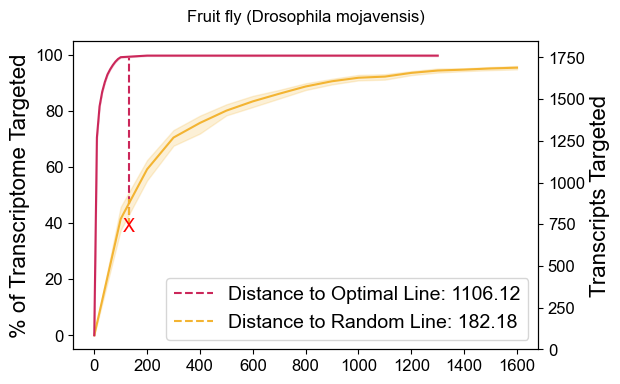

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


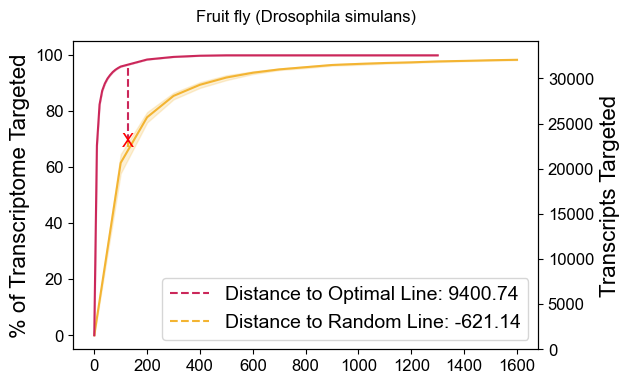

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


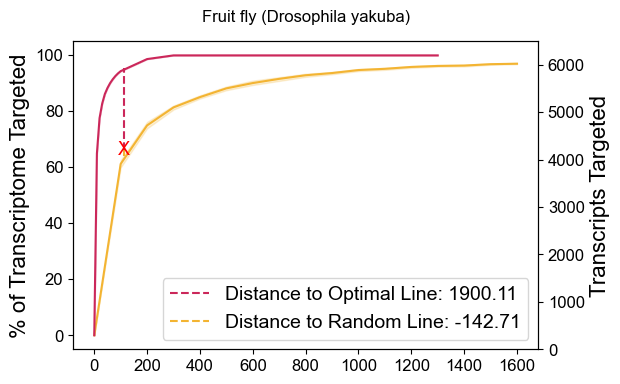

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


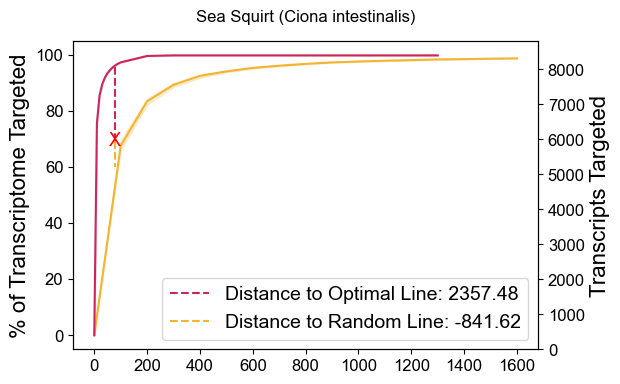

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


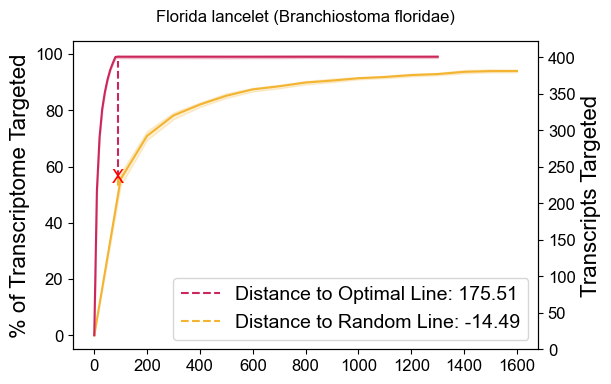

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


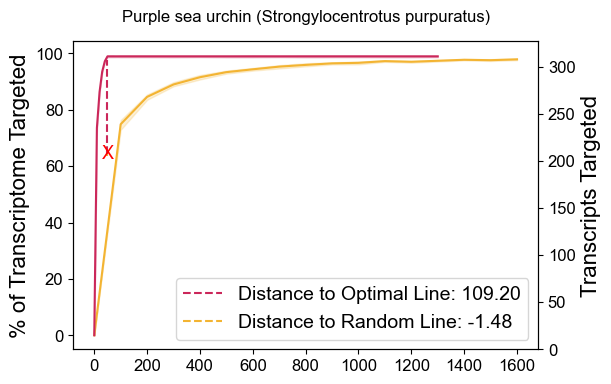

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


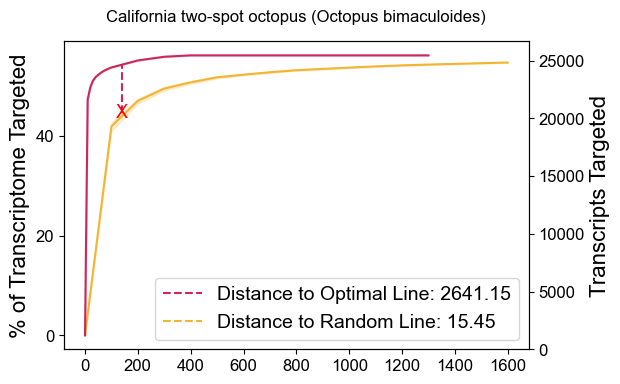

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


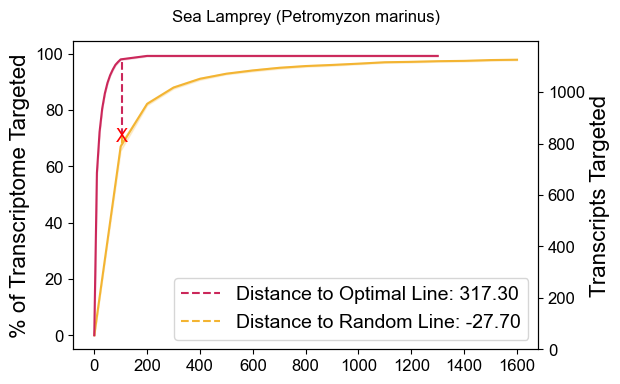

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: overflow encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


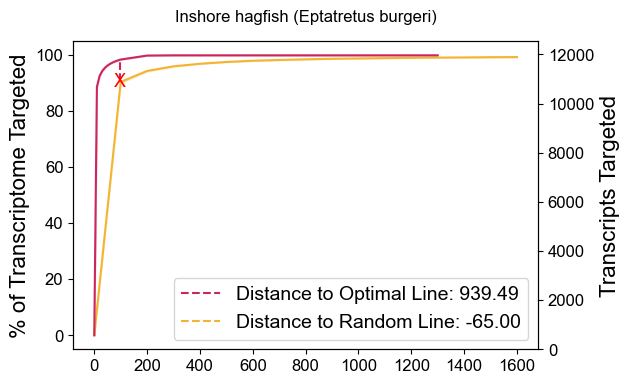

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(glf, x, y, p0=[0,1,np.quantile(x,.25),np.max(y),.4], maxfev=10000)


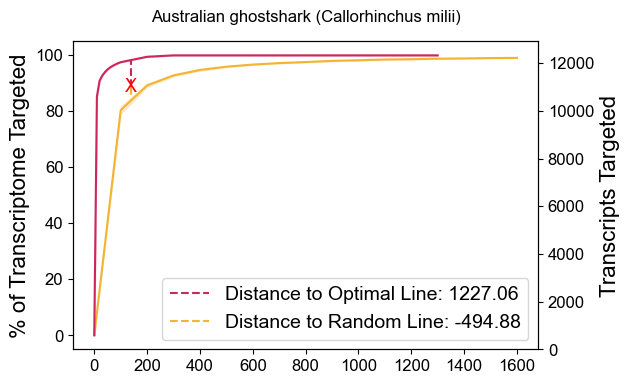

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: overflow encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


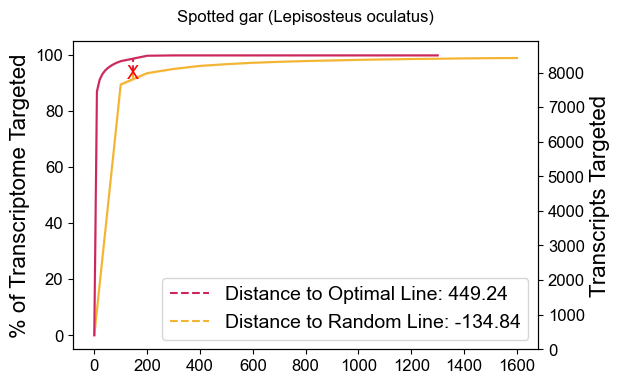

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(glf, x, y, p0=[0,1,np.quantile(x,.25),np.max(y),.4], maxfev=10000)


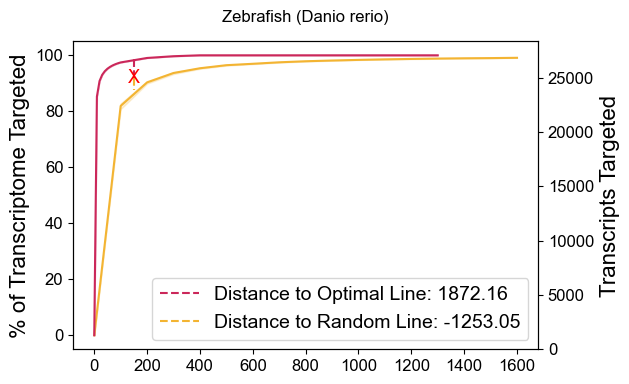

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


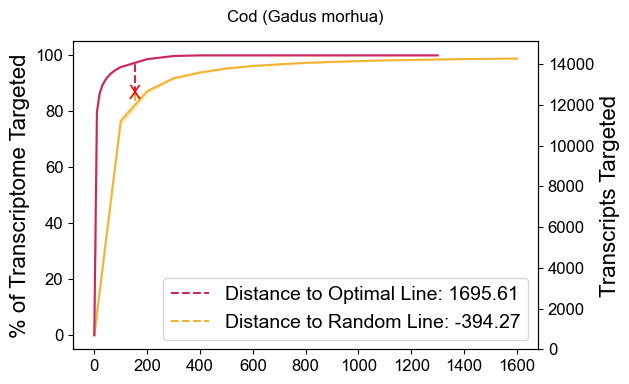

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(glf, x, y, p0=[0,1,np.quantile(x,.25),np.max(y),.4], maxfev=10000)


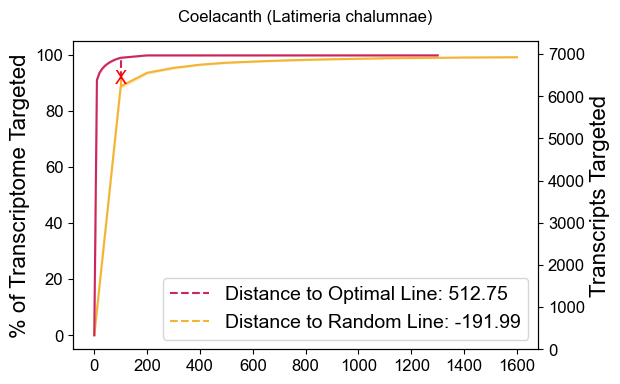

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


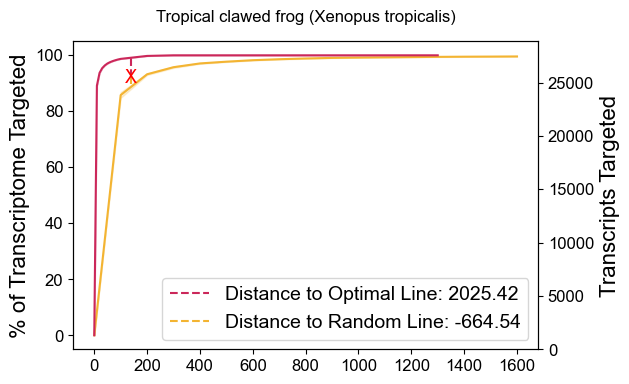

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


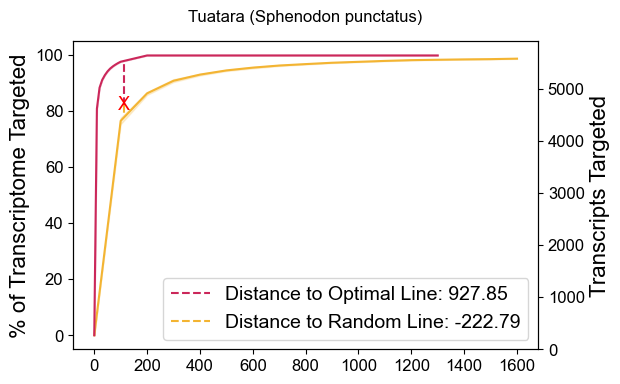

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


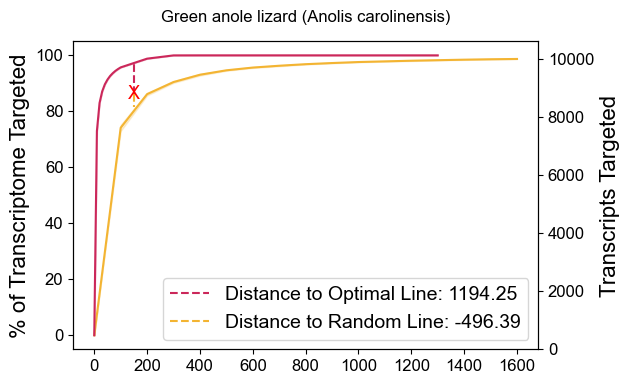

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(glf, x, y, p0=[0,1,np.quantile(x,.25),np.max(y),.4], maxfev=10000)


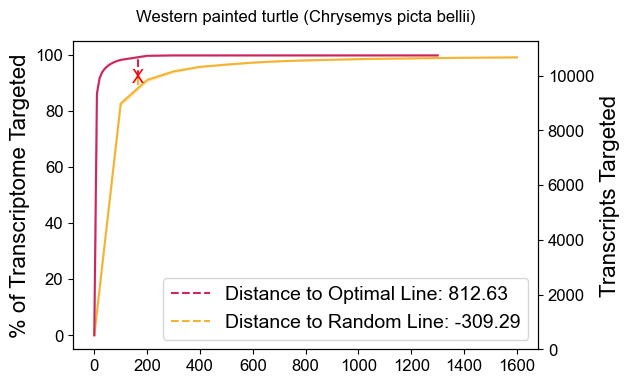

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(glf, x, y, p0=[0,1,np.quantile(x,.25),np.max(y),.4], maxfev=10000)


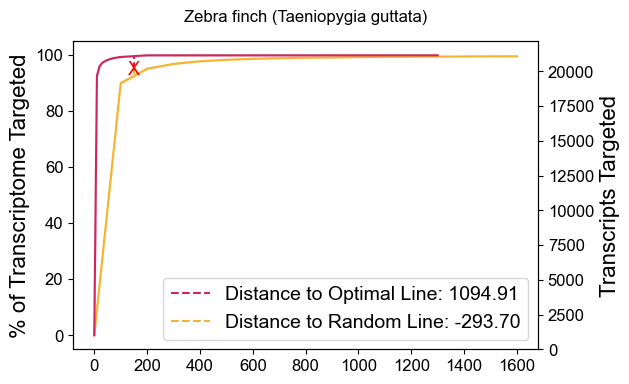

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(glf, x, y, p0=[0,1,np.quantile(x,.25),np.max(y),.4], maxfev=10000)


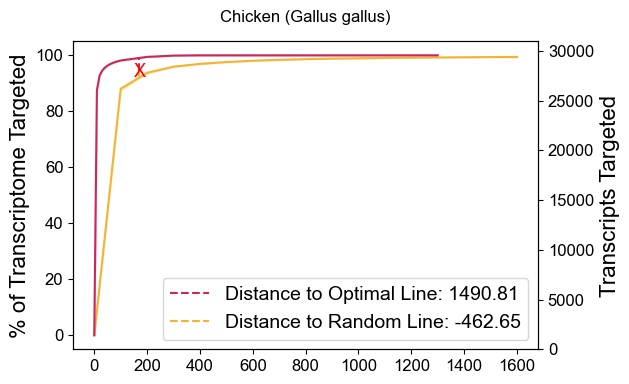

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


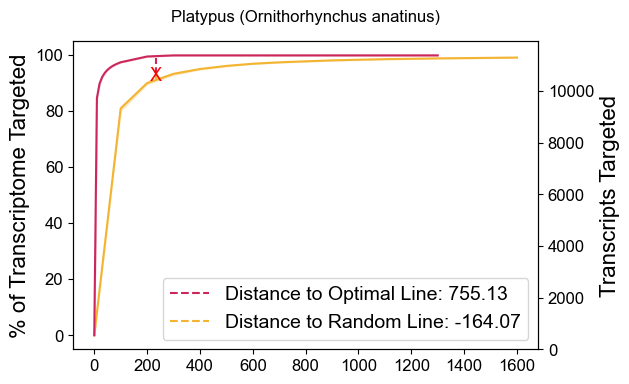

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


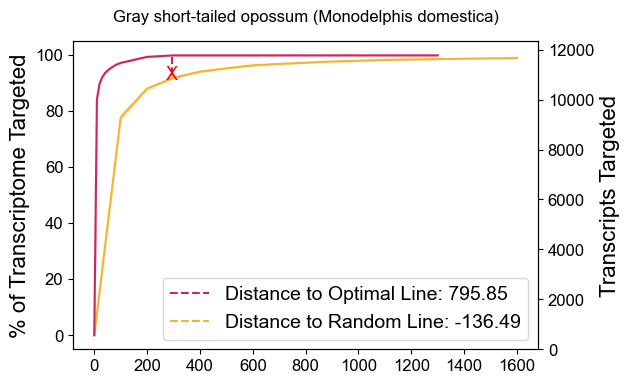

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: overflow encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


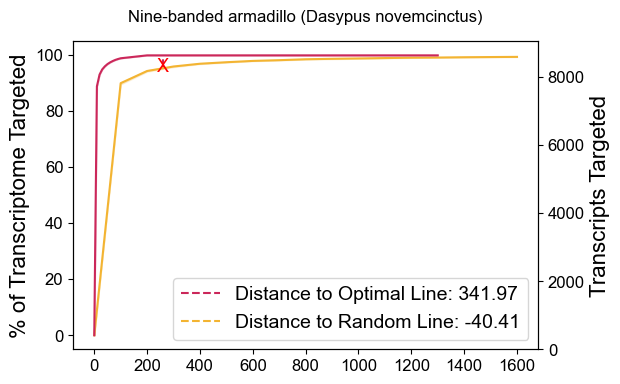

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


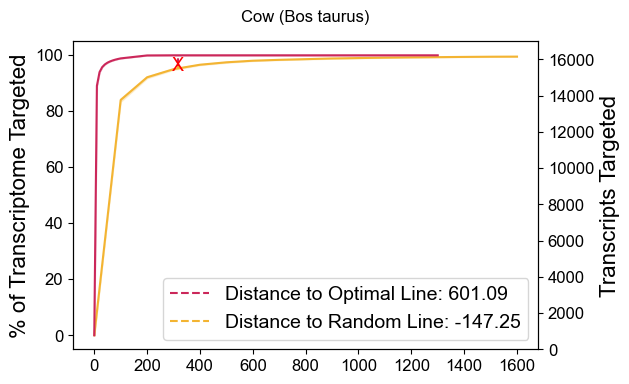

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


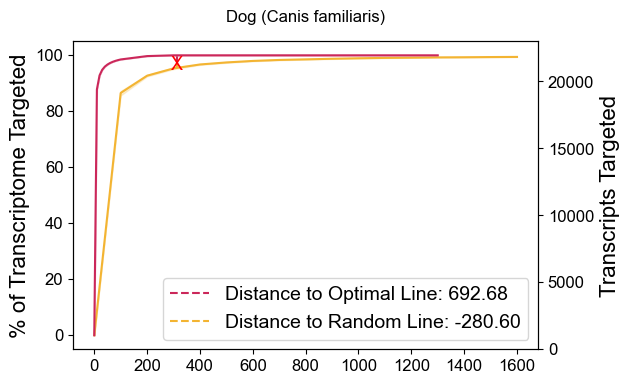

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


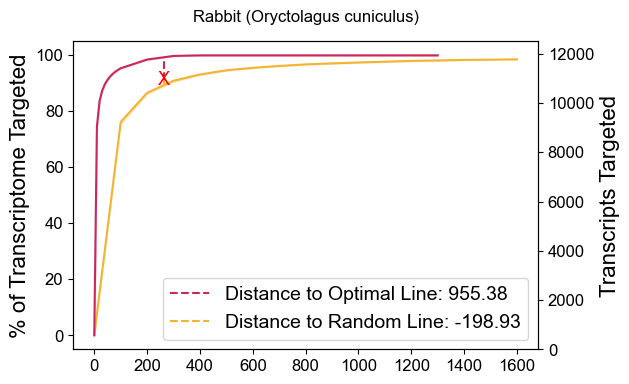

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


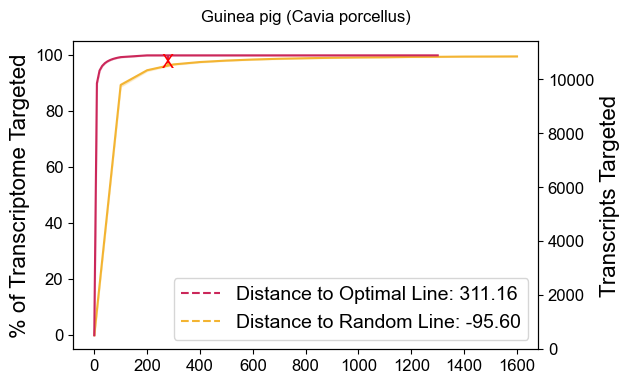

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


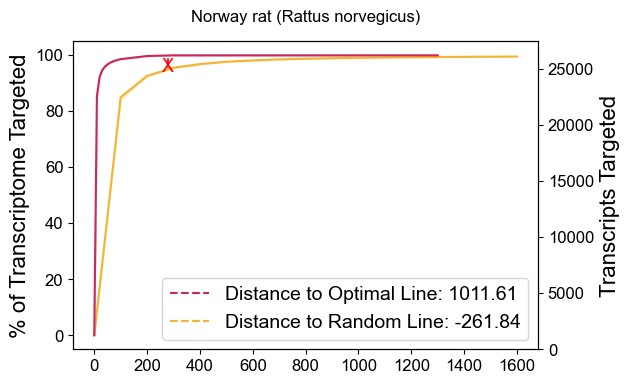

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


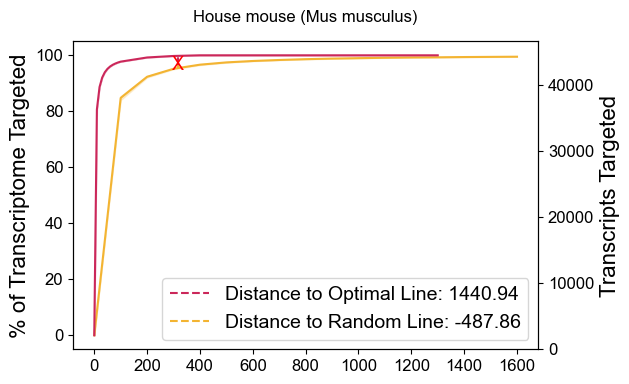

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/243604688.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  genome_size = int(df['Gene Number'][index])
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: divide by zero encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_10809/338291912.py:3: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )


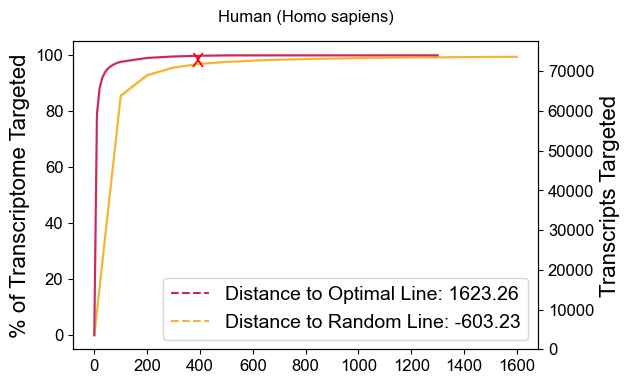

In [47]:
#run simulate_plot() here
sites = ['B']
for species in species_list:
    for site in sites:
        simulate_plot(species[0],species[1],site)